Do all data preprocessing outside of model scope

Also if all targets are same scale, only need one amplitude constant

Try different priors, reasonable ones help a lot

Especially if it's ending up in unreasonable parts of space

Henry thinks you can put priors on those transformed parameters

Also probably possible to fit parameters in different sections

So fit sigma first, etc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path_sim = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n5500_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path = '/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# PyMC 

## ADVI

In [2]:
#df_sim = pd.read_csv(df_path_sim)
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)

In [9]:
model = sfp.monte_carlo.setup_model(df_sim)

In [10]:
with model:
    advi=pm.ADVI()
    advi_fit = advi.fit(10000, obj_optimizer=pm.adam(learning_rate=.01), )#more_replacements=map_tensor_batch,)# callbacks=[tracker])

Average Loss = -5,401.4: 100%|██████████| 10000/10000 [00:05<00:00, 1704.01it/s]
Finished [100%]: Average Loss = -5,401.4


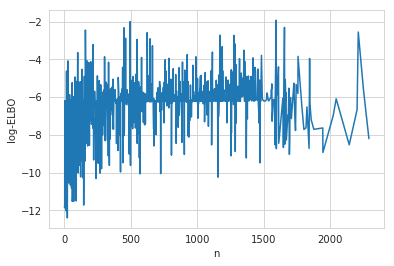

In [11]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [12]:
advi_trace = advi_fit.sample(500)

In [13]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
voxel_norm,0.259179,0.004831,0.000194,0.249980,0.269167
sigma,0.995364,0.018782,0.000757,0.951151,1.026065
sf_ecc_slope,0.509445,0.008101,0.000373,0.492128,0.523162
sf_ecc_intercept,0.448265,0.028002,0.001332,0.394971,0.500991


/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


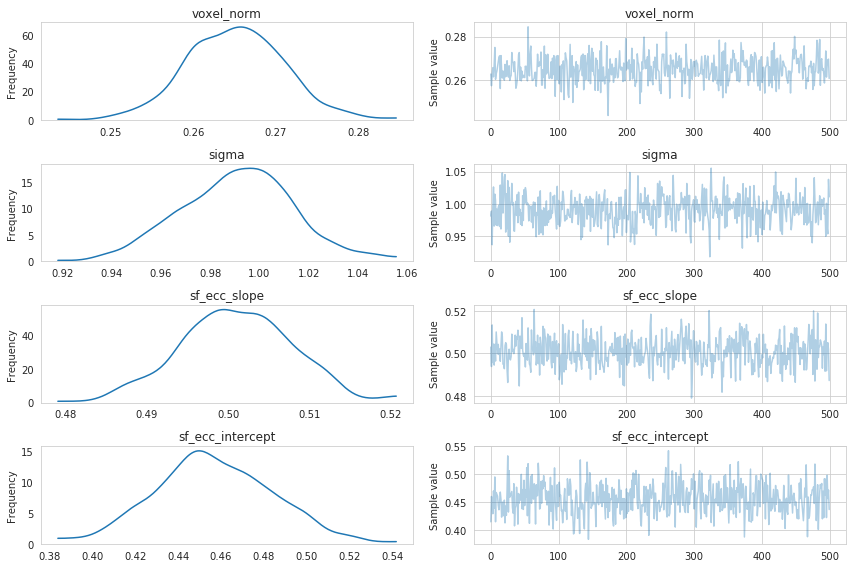

In [157]:
pm.traceplot(advi_trace);#, ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

## MCMC

In [48]:
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)
df_sim.to_csv('test.csv')

In [74]:
inference_data = sfp.monte_carlo.main('test.csv', n_chains=8, n_samples=500,)

Started with 100 voxels, after filtering with df_filter string drop_voxels_with_negative_amplitudes have 0 voxels
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sf_ecc_intercept, sf_ecc_slope, sigma, voxel_norm]
Sampling 8 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3274.28draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 500/500 [00:00<00:00, 1152.64it/s]


In [83]:
inference_data = az.load_data('test2.nc')

In [84]:
az.summary(inference_data)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.27,0.00,0.0,0.26,0.27,2502.0,1.00
sigma,1.00,0.02,0.0,0.97,1.02,2244.0,1.00
sf_ecc_slope,0.51,0.01,0.0,0.49,0.53,2095.0,1.01
sf_ecc_intercept,0.45,0.04,0.0,0.37,0.52,2245.0,1.01


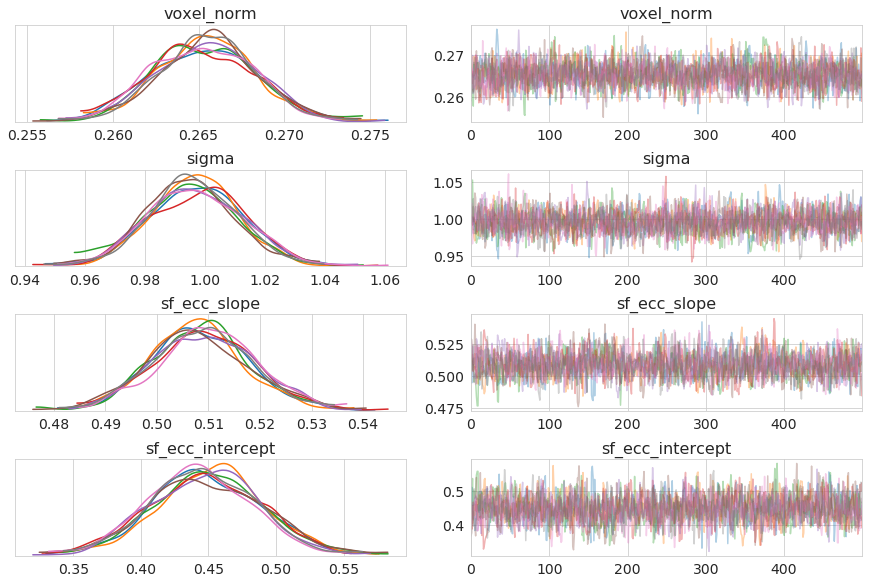

In [85]:
az.plot_trace(inference_data);

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


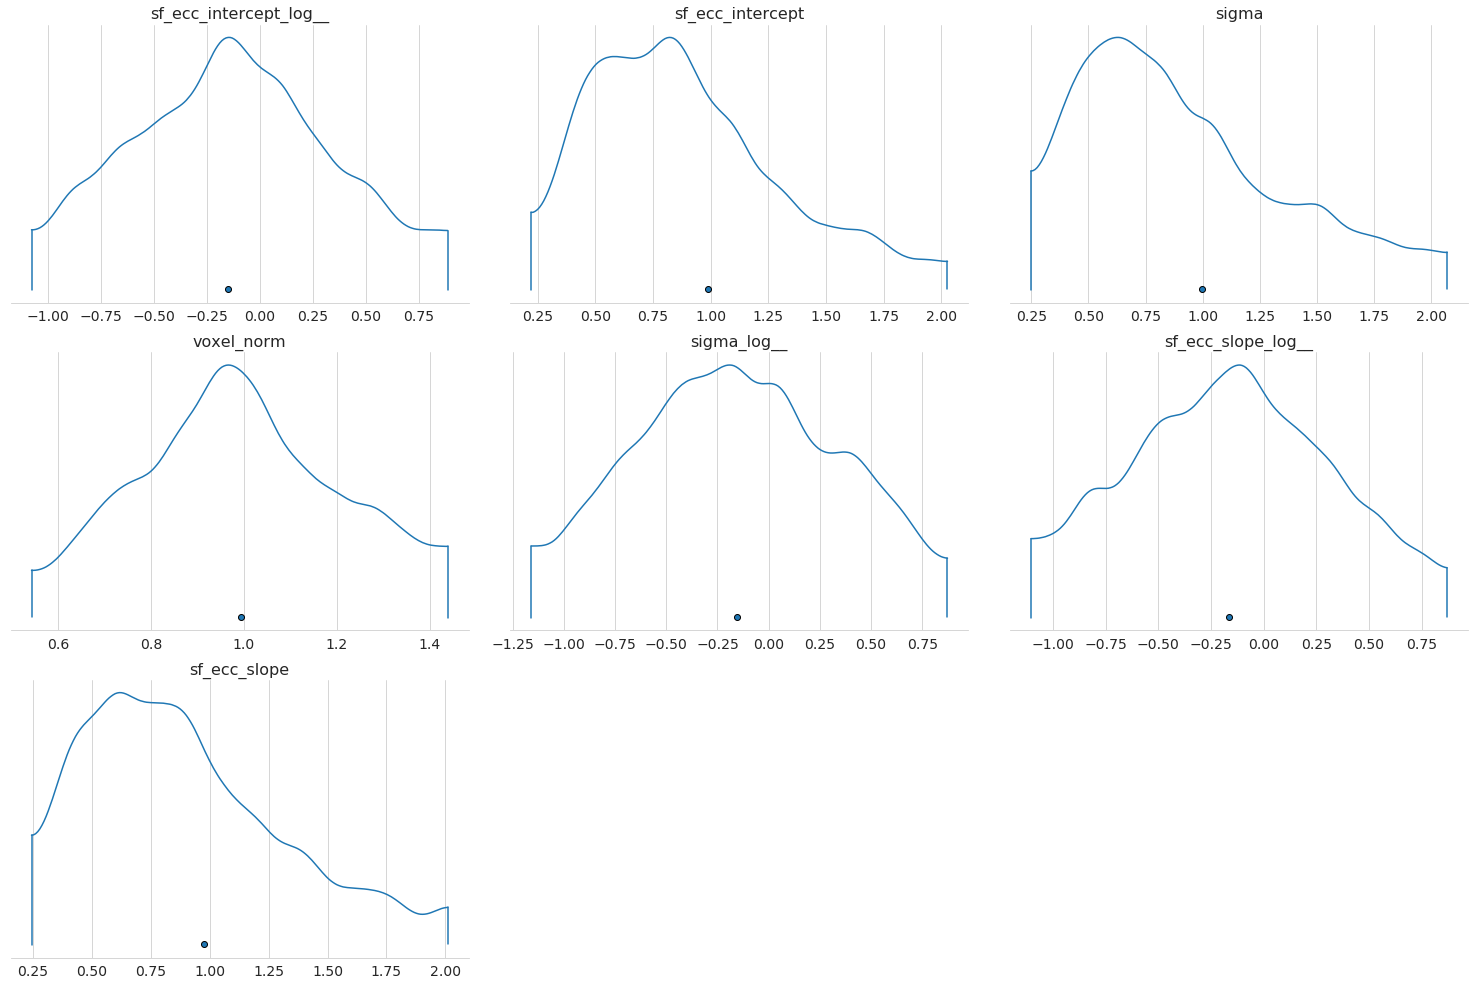

In [56]:
az.plot_density(inference_data.prior);